# Spin Chain Hamiltonians and Trotter Circuits
## A Comparative Study of Models and Parameterizations

TenSynth includes built-in support for several quantum spin chain Hamiltonians and their Trotter decompositions. In this notebook you will:

1. Construct four standard spin chain models (TFIM, XXZ, Heisenberg, XY)
2. Inspect the Hamiltonian term structure (`LocalTerm`)
3. Generate Trotter circuits at different orders and step counts
4. Compare Trotter error bounds across models
5. Explore different gate parameterizations and verify unitarity
6. Compare total parameter counts across models and parameterizations

## Setup

In [1]:
using Pkg
Pkg.activate(joinpath(@__DIR__, ".."))

using TenSynth
using TenSynth.Core
using TenSynth.Hamiltonians

using LinearAlgebra
using Random
using Plots
gr()

Random.seed!(42)
println("TenSynth loaded successfully.")

  Activating project at `~/Documents/Programming/PhD/ClaudeCodeExperiments/TenSynth_Master/TenSynthRepo/TenSynth`


TenSynth loaded successfully.


## 1. Four Spin Chain Models

TenSynth provides constructors for four standard 1D spin-½ models:

| Model | Hamiltonian | Constructor |
|-------|------------|-------------|
| **TFIM** | $H = -J \sum Z_i Z_{i+1} - h \sum X_i$ | `TFIMHamiltonian(n; J, h)` |
| **XXZ** | $H = J_{xy} \sum (X_i X_{i+1} + Y_i Y_{i+1}) + J_z \sum Z_i Z_{i+1}$ | `XXZHamiltonian(n; Jxy, Jz, h)` |
| **Heisenberg** | $H = J \sum \mathbf{S}_i \cdot \mathbf{S}_{i+1}$ | `HeisenbergHamiltonian(n; J, h)` |
| **XY** | $H = J \sum (X_i X_{i+1} + Y_i Y_{i+1})$ | `XYHamiltonian(n; J, h)` |

The `unit_cell` argument specifies the number of sites in the repeating unit (used for infinite-chain methods). Heisenberg is the isotropic special case of XXZ ($J_{xy} = J_z$), and XY is the $J_z = 0$ case.

In [2]:
H_tfim = TFIMHamiltonian(2; J=1.0, h=1.0)
H_xxz  = XXZHamiltonian(2; Jxy=1.0, Jz=0.5)
H_heis = HeisenbergHamiltonian(2; J=1.0)
H_xy   = XYHamiltonian(2; J=1.0)

models = [("TFIM", H_tfim), ("XXZ", H_xxz), ("Heisenberg", H_heis), ("XY", H_xy)]

for (name, H) in models
    n_two = length(get_two_site_terms(H))
    n_single = length(get_single_site_terms(H))
    println("$name: $(H.unit_cell)-site unit cell, $n_two two-site terms, $n_single single-site terms")
end

TFIM: 2-site unit cell, 2 two-site terms, 0 single-site terms
XXZ: 2-site unit cell, 6 two-site terms, 0 single-site terms
Heisenberg: 2-site unit cell, 6 two-site terms, 0 single-site terms
XY: 2-site unit cell, 4 two-site terms, 0 single-site terms


## 2. Inspecting Hamiltonian Terms

Each Hamiltonian is stored as a list of `LocalTerm` objects. A `LocalTerm` contains an operator matrix, the site indices it acts on, and a coefficient. You can query terms with `get_two_site_terms()`, `get_single_site_terms()`, and extract the full operator via `get_matrix()`.

In [3]:
# Inspect the TFIM terms
println("TFIM Hamiltonian terms:")
for (i, term) in enumerate(H_tfim.terms)
    kind = is_two_site(term) ? "two-site" : "single-site"
    println("  Term $i: $kind on sites $(term.sites), coeff = $(term.coefficient)")
end

# Show the full local Hamiltonian on bond (1,2)
println("\nLocal Hamiltonian on bond (1,2):")
for (name, H) in models
    H_local = get_local_hamiltonian(H, (1, 2))
    evals = round.(sort(real(eigvals(H_local))), digits=4)
    println("  $name eigenvalues: $evals")
end

TFIM Hamiltonian terms:
  Term 1: two-site on sites (1, 2), coeff = 1.0
  Term 2: two-site on sites (2, 1), coeff = 1.0

Local Hamiltonian on bond (1,2):
  TFIM eigenvalues: [-1.4142, -1.0, 1.0, 1.4142]
  XXZ eigenvalues: [-2.5, 0.5, 0.5, 1.5]
  Heisenberg eigenvalues: [-3.0, 1.0, 1.0, 1.0]
  XY eigenvalues: [-2.0, 0.0, 0.0, 2.0]


## 3. Trotterizing the Hamiltonians

The `trotterize()` function creates a `ParameterizedCircuit` that approximates the time evolution $U = e^{-iHt}$ via Suzuki-Trotter decomposition. Three orders are supported:

- **First order**: $U_1(\Delta t) = e^{-iH_A \Delta t} e^{-iH_B \Delta t}$
- **Second order**: $U_2(\Delta t) = e^{-iH_A \Delta t/2} e^{-iH_B \Delta t} e^{-iH_A \Delta t/2}$
- **Fourth order**: Suzuki's recursive formula using 5 applications of $U_2$

Each order produces a different number of gates per Trotter step.

In [4]:
t = 1.0
n_steps = 10

println("Trotter circuits (t=$t, n_steps=$n_steps):\n")
println(rpad("Model", 14), rpad("Order", 10), rpad("Gates", 8), "Parameters")
println("-"^45)

for (name, H) in models
    for order in [:first, :second, :fourth]
        circuit = trotterize(H, t; order=order, n_steps=n_steps)
        ng = length(circuit.gates)
        np = sum(length(g.params) for g in circuit.gates)
        println(rpad(name, 14), rpad(string(order), 10), rpad(string(ng), 8), np)
    end
    println()
end

Trotter circuits (t=1.0, n_steps=10):

Model         Order     Gates   Parameters
---------------------------------------------
TFIM          first     20      140
TFIM          second    20      140
TFIM          fourth    100     700

XXZ           first     60      420
XXZ           second    60      420
XXZ           fourth    300     2100

Heisenberg    first     60      420
Heisenberg    second    60      420
Heisenberg    fourth    300     2100

XY            first     40      280
XY            second    40      280
XY            fourth    200     1400



## 4. Trotter Error Bounds

The Trotter decomposition introduces an error that depends on the step size $\Delta t = t/n_\text{steps}$ and the Hamiltonian norm. `trotter_error_bound()` provides a rough upper bound that scales as:
- First order: $O(\Delta t)$
- Second order: $O(\Delta t^2)$
- Fourth order: $O(\Delta t^4)$

Let's compare the error bounds across all four models at second order.

TFIM: steps=2 → 5.66,  steps=64 → 0.00552
XXZ: steps=2 → 31.2,  steps=64 → 0.0305
Heisenberg: steps=2 → 54.0,  steps=64 → 0.0527
XY: steps=2 → 16.0,  steps=64 → 0.0156


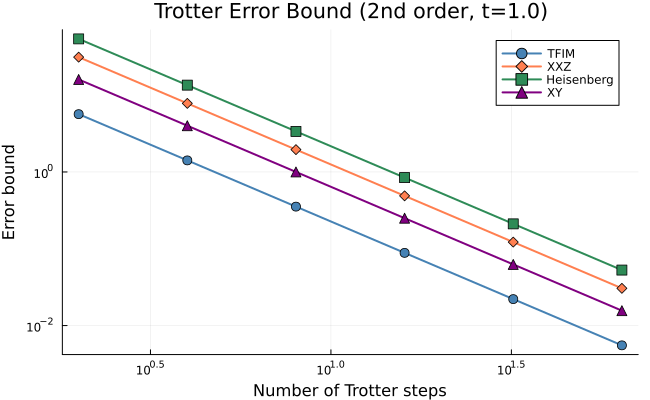

In [5]:
steps_range = [2, 4, 8, 16, 32, 64]
t_total = 1.0

p = plot(title="Trotter Error Bound (2nd order, t=$t_total)",
         xlabel="Number of Trotter steps", ylabel="Error bound",
         xscale=:log10, yscale=:log10,
         legend=:topright, size=(650, 400))

markers = [:circle, :diamond, :square, :utriangle]
colors = [:steelblue, :coral, :seagreen, :purple]

for (i, (name, H)) in enumerate(models)
    bounds = [trotter_error_bound(H, t_total; order=:second, n_steps=ns) for ns in steps_range]
    plot!(p, steps_range, bounds, label=name, marker=markers[i],
          linewidth=2, markersize=5, color=colors[i])
    println("$name: steps=2 → $(round(bounds[1], sigdigits=3)),  steps=64 → $(round(bounds[end], sigdigits=3))")
end

p

All models show the expected $O(\Delta t^2)$ scaling (parallel lines on the log-log plot). The vertical offset reflects the Hamiltonian norm — models with more interaction terms or larger coefficients have larger error bounds at the same step count.

## 5. Gate Parameterizations

TenSynth supports several parameterizations for two-qubit gates, each trading off between expressiveness and parameter count:

| Parameterization | Parameters | Description |
|-----------------|-----------|-------------|
| `ZZParameterization` | 1 | $\text{CNOT} \cdot (I \otimes R_Z) \cdot \text{CNOT}$ — ZZ rotation only |
| `ZZXParameterization` | 3 | ZZ rotation + X rotations on both qubits |
| `DressedZZParameterization` | 7 | Single-qubit XYZ rotations on each qubit + ZZ interaction |
| `PauliGeneratorParameterization` | 15 | Full $e^{i \sum_j p_j P_j}$ over all two-qubit Pauli generators |

More parameters means more expressiveness but also a larger optimization landscape.

In [6]:
parameterizations = [
    ("ZZ",             ZZParameterization()),
    ("ZZX",            ZZXParameterization()),
    ("DressedZZ",      DressedZZParameterization()),
    ("PauliGenerator", PauliGeneratorParameterization()),
]

println("Parameterization summary:")
for (name, p) in parameterizations
    println("  $name: $(n_params(p)) parameters per gate")
end

Parameterization summary:
  ZZ: 1 parameters per gate
  ZZX: 3 parameters per gate
  DressedZZ: 7 parameters per gate
  PauliGenerator: 15 parameters per gate


## 6. Parameterization Demo

Each parameterization maps a vector of real numbers to a unitary matrix via `to_matrix()`. Let's construct `ParameterizedGate` objects with random parameters and verify they produce valid unitaries.

In [7]:
Random.seed!(42)

for (name, p) in parameterizations
    params = 0.3 * randn(n_params(p))
    gate = ParameterizedGate(p, (1, 2), params)
    U = to_matrix(gate)
    unitary_err = norm(U' * U - I)
    println("$name ($(n_params(p)) params): $(size(U)) matrix, ",
            "unitarity error = $(round(unitary_err, sigdigits=2))")
end

ZZ (1 params): (4, 4) matrix, unitarity error = 0.0
ZZX (3 params): (4, 4) matrix, unitarity error = 1.4e-15
DressedZZ (7 params): (4, 4) matrix, unitarity error = 1.1e-15
PauliGenerator (15 params): (4, 4) matrix, unitarity error = 5.0e-16


## 7. Parameter Counts: Models × Parameterizations

The total number of variational parameters in a Trotter circuit depends on both the model (which determines the number of gates) and the parameterization (which determines the parameters per gate). Let's compare.

In [8]:
param_types = [
    ("DressedZZ",      DressedZZParameterization()),
    ("PauliGenerator", PauliGeneratorParameterization()),
]

model_names = [name for (name, _) in models]
dzz_total = Float64[]
pg_total = Float64[]

println(rpad("Model", 14), rpad("DressedZZ", 14), "PauliGenerator")
println("-"^42)

for (name, H) in models
    c_dzz = trotterize(H, 1.0; order=:second, n_steps=10, parameterization=DressedZZParameterization())
    c_pg  = trotterize(H, 1.0; order=:second, n_steps=10, parameterization=PauliGeneratorParameterization())
    n_dzz = sum(length(g.params) for g in c_dzz.gates)
    n_pg  = sum(length(g.params) for g in c_pg.gates)
    push!(dzz_total, n_dzz)
    push!(pg_total, n_pg)
    println(rpad(name, 14), rpad(string(n_dzz), 14), n_pg)
end

Model         DressedZZ     PauliGenerator
------------------------------------------
TFIM          140           300
XXZ           420           900
Heisenberg    420           900
XY            280           600


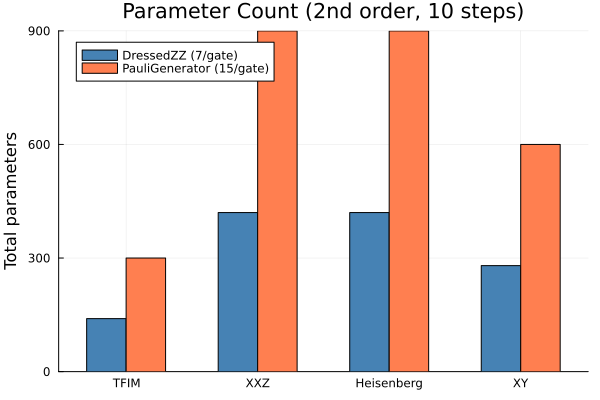

In [9]:
x = 1:4
p = plot(size=(600, 400), legend=:topleft)
bar!(p, x .- 0.15, dzz_total, bar_width=0.3,
     label="DressedZZ (7/gate)", color=:steelblue)
bar!(p, x .+ 0.15, pg_total, bar_width=0.3,
     label="PauliGenerator (15/gate)", color=:coral)
xticks!(p, x, model_names)
ylabel!(p, "Total parameters")
title!(p, "Parameter Count (2nd order, 10 steps)")

p

The PauliGenerator parameterization uses roughly twice as many parameters as DressedZZ, since it has 15 parameters per gate versus 7. The gate count is the same for both — only the per-gate parameterization differs. In practice, DressedZZ is often sufficient for Hamiltonians with ZZ-type interactions (TFIM), while PauliGenerator is needed for more general models (XXZ, Heisenberg).

## Summary

In this notebook you learned:

- How to construct **four spin chain Hamiltonians** (TFIM, XXZ, Heisenberg, XY) and inspect their terms
- How to generate **Trotter circuits** at different orders with `trotterize()`
- That **higher-order Trotter** formulas give tighter error bounds at the same step count
- That different **gate parameterizations** trade off expressiveness (parameter count) for simplicity
- How to construct `ParameterizedGate` objects and verify unitarity with `to_matrix()`

**Key functions used:**
- `TFIMHamiltonian(n; J, h)`, `XXZHamiltonian(n; Jxy, Jz, h)`, `HeisenbergHamiltonian(n; J, h)`, `XYHamiltonian(n; J, h)`
- `get_two_site_terms(H)`, `get_single_site_terms(H)`, `get_local_hamiltonian(H, sites)`
- `LocalTerm`, `is_single_site(term)`, `is_two_site(term)`, `get_matrix(term)`
- `trotterize(H, t; order, n_steps, parameterization)`
- `trotter_error_bound(H, t; order, n_steps)`
- `DressedZZParameterization()`, `PauliGeneratorParameterization()`, `ZZParameterization()`, `ZZXParameterization()`
- `ParameterizedGate(parameterization, qubits, params)`, `to_matrix(gate)`, `n_params(p)`

**Next**: Notebook 06 explores infinite MPS (iMPS) ground states via iTEBD and state preparation circuits.